<img src = "images/Logo.png" width = 220, align = "left">

<h1 align=center><font size = 6>Blood pressure as function of age and weight</font></h1>
<h2 align=center><font size = 5>Lab Exercise 3.1</font></h2>
<h3 align=center><font size = 4><b>Advanced Machine Learning Made Easy<br></b><small>From Theory to Practice with NumPy and scikit-learn<br><i>Volume 1: Generalized Linear Models</i></font></h3>

## Introduction

In the previous chapter, we already suspected that the systolic blood pressure of a person should be affected not only by the age of a person but also by other factors, like weight. So, let's imagine that we conduct another survey where we not only measure the blood pressure of the person while recording the person's age but also measuring his/her weight in pounds. The result of the survey will be a small dataset containing only 11 observations (we ran out of money, you know, so we could not afford to collect more data). Each observation consists of the measured blood pressure of the individual as the output variable and the age and weight of the person as the input variables. Again, this is a toy dataset, but it will help to understand the basics of the multiple linear regression. Moreover, it helps to visualize the elements of the vectors and matrices much easier. <br> 
**Note**: *The original dataset can be found at http://college.cengage.com/mathematics/brase/understandable_statistics/7e/students/datasets/mlr/frames/mlr02.html.*

### Table of contents
1. [Reading the data](#ReadingData)
2. [Scatter plot with the estimated regression plane](#ScatterPlot)
3. [Calculate the hat matrix and the covariance matrices](#HatAndCov)
4. [Make hypothesis testing](#Hypothesis)
5. [Calculate RSS and R-squared](#CalcRSSR2)
6. [Using scikit-learn and statsmodel libraries](#SklearnStatsmodel)
7. [Checking for colliniarity](#CheckColliniarity)

## 1. Reading the data <a name="ReadingData"></a>

As a first step, we import the NumPy, Pandas, respective matplotlib libraries.

In [1]:
import numpy as np
from numpy.linalg import inv, matrix_rank, eigh
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import os
%matplotlib inline

Next, we read the *BloodpressureAgeWeight.csv* file into a pandas dataframe, which contains the measured systolic blood pressure for 11 people with different ages and weights.

In [2]:
data = pd.read_csv(os.path.join('data','BloodpressureAgeWeight.csv'))

We will print out the dataset to have the first glimpse of it. The dataset contains four columns: index, systolic blood pressure, age in years, and weight in pounds. There are 11 unordered data points (observations). <br>
**Note**: *Indexing of pandas dataframe, as well as NumPy arrays, starts from zero and not from one. The Index column shown below is not equivalent to the pandas indexing.*

In [3]:
print("Dataset of the systolic blood pressure vs. age and weight:")
print("==========================================================\n",data.to_string(index=False))

Dataset of the systolic blood pressure vs. age and weight:
  Systolic blood pressure  Age in years  Weight in pounds
                     132            52               173
                     143            59               184
                     153            67               194
                     162            73               211
                     154            64               196
                     168            74               220
                     137            54               188
                     149            61               188
                     159            65               207
                     128            46               167
                     166            72               217


Extract the input and output values from the pandas dataframe into the design matrix $\mathbf{\dot X}$ and vector $\mathbf{y}$. Also, extract the number of observations available in the dataset.

**Note**: * To follow the mathematical notations of the book the following naming convention is applied for variables in the code: scalar variables will use lower case (except for $N$ as the number of observations, $D$ as the number of input variables), vector variables will use lower case followed by an underscore, and matrix variables will use upper case.* 

First, print out the input matrix $X$. For better visualization, it is converted to a pandas dataframe.

In [4]:
X=np.array(data[["Age in years","Weight in pounds"]])
pd.DataFrame(X,index=range(1,12),columns=[['$\mathbf x_1$','$\mathbf x_2$']])

,$\mathbf x_1$,$\mathbf x_2$
1,52,173
2,59,184
3,67,194
4,73,211
5,64,196
6,74,220
7,54,188
8,61,188
9,65,207
10,46,167


Next, print out the number of input variables and the number of observations:

In [5]:
N,D=X.shape
print("Number of observations:",N)
print("Number of independent variables:",D)

Number of observations: 11
Number of independent variables: 2


Now, let's insert a column at the beginning of $\mathbf X$ corresponding to the constant term (intercept) then make it visible the resulted design matrix $\mathbf {\dot X}$. Again, the NumPy array is converted into a pandas dataframe for better visualization.

In [6]:
Xdot=np.insert(X,0,np.ones(N),axis=1)
pd.DataFrame(Xdot,index=range(1,12),columns=[['$\mathbf x_0$','$\mathbf x_1$','$\mathbf x_2$']])

,$\mathbf x_0$,$\mathbf x_1$,$\mathbf x_2$
1,1,52,173
2,1,59,184
3,1,67,194
4,1,73,211
5,1,64,196
6,1,74,220
7,1,54,188
8,1,61,188
9,1,65,207
10,1,46,167


Let's check the rank of the design matrix. If none of the columns can be expressed as a linear combination of the rest of the colors, then the rank of the design matrix should be equal to the number of its columns.

In [7]:
print("The rank of the design matrix Xdot is:",matrix_rank(Xdot))

The rank of the design matrix Xdot is: 3


Thus, the rank of the design matrix is equal to the number of input variables with intercept included.

Finally, create the output vector $\mathbf y$ and print out the result.

In [8]:
y_=np.array(data["Systolic blood pressure"])[:,np.newaxis]
pd.DataFrame(y_,index=range(1,12),columns=[['$\mathbf y$']])

,$\mathbf y$
1,132
2,143
3,153
4,162
5,154
6,168
7,137
8,149
9,159
10,128


After this, we should be confident about how an input matrix (design matrix) and output vector should look, respectively, how they can be created from a dataset.

## 2. Scatter plot with the estimated regression plane <a name="ScatterPlot"></a>

Make a scatterplot of the observations from the dataset to have a grasp about your data. If you want to apply linear regression, a first visual check is always useful to see the trend in your data.

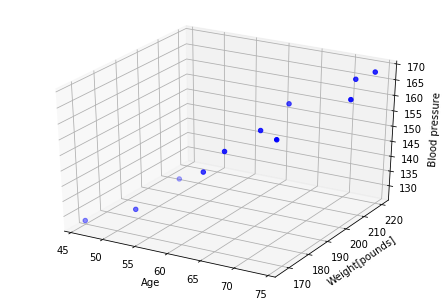

In [9]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Xdot[:,1], Xdot[:,2], y_, c='b')
ax.set_xlabel('Age')
ax.set_ylabel('Weight[pounds]')
ax.set_zlabel('Blood pressure')
plt.show()

As can be observed from the scatter plot, there is some linear trend between the blood pressure of a person vs. his/her age and weight. 

The weight vector $\mathbf w$ (vector of regression coefficients) can be calculated from the design matrix as $\mathbf{w}=(\mathbf{\dot X}^T\mathbf{\dot X})^{-1}\mathbf{\dot X}^T\mathbf{y}$ as was derived in the book.

**Note**: *Conversion from the mathematical notation to Python code is straightforward when using NumPy operators and methods.*

In [10]:
w_=inv(Xdot.T@Xdot)@Xdot.T@y_
print("Vector of regression coefficients:")
pd.DataFrame(w_,index=[['$w_0$','$w_1$','$w_2$']],columns=['$\mathbf w$ '])

Vector of regression coefficients:


,$\mathbf w$
$w_0$,30.994103
$w_1$,0.861415
$w_2$,0.334859


The first term represents the constant or intercept ($w_0=b=30.994$), the second the coefficient for the input variable age ($w_1=0.861$), while the third term the coefficient for the input variable weight ($w_2=0.335$). One unit change in age, while keeping the other input variable constant, corresponds to 0.861 unit change in blood pressure. For example, if a person gets one year older and we do not expect that the weight is changed, on average, the blood pressure increases with 0.861 unit. That is slightly lower than what we get from the other dataset, but if we look at the age values, we can observe that now there are only older people in the dataset, not young people. Similarly, one unit change in weight while keeping the age constant corresponds to 0.33 unit change in blood pressure. If there are two persons at the same age, but with different weights, then each additional one pound (0.453kg) difference results in average 0.335 unit difference in blood pressure. For example, if the difference is 60 pounds (27.24kg) between a slim and a fat person, then on average, the blood pressure of a fat person should be 20 units more.

Now, make the plot of the estimated regression plain.

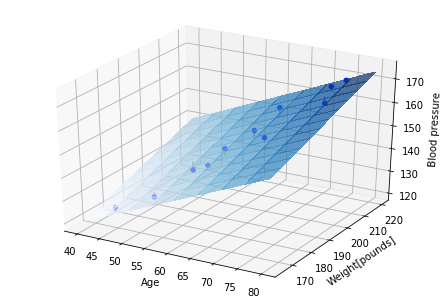

In [11]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Xdot[:,1], Xdot[:,2], y_, c='b', alpha=1)
# Creating the meshgrid for x (age),y(weigth) and calculating the value of z (surface)
xx, yy = np.meshgrid(np.arange(40,85,5), np.arange(165,225,5))
zz = w_[0,0]+w_[1,0]*xx+w_[2,0]*yy
surf = ax.plot_surface(xx, yy, zz, cmap=cm.Blues, linewidth=0, antialiased=False, alpha=0.7)
for i in range(N):
    ax.plot([Xdot[i,1],Xdot[i,1]],[Xdot[i,2],Xdot[i,2]],[y_[i,0],w_[0,0]+w_[1,0]*Xdot[i,1]+w_[2,0]*Xdot[i,2]])
ax.set_xlabel('Age')
ax.set_ylabel('Weight[pounds]')
ax.set_zlabel('Blood pressure')
plt.show() 

With two input variables, the obtained result is not a regression line but a regression plane. 

## 3. Calculate the hat matrix and the covariance matrices <a name="HatAndCov"></a>

We can also calculate the hat matrix: $\mathbf{H}=\mathbf{\dot X}(\mathbf{\dot X}^T\mathbf{\dot X})^{-1}\mathbf{\dot X}^T$. Again, you can see how easily the mathematical expression can be translated to Python/Numpy code.

In [12]:
H=Xdot@inv(Xdot.T@Xdot)@Xdot.T
print("Shape of the hat matrix is:",H.shape)

Shape of the hat matrix is: (11, 11)


The hat matrix is a squared matrix with number of rows/columns equal to the number of observations $N$. Check the rank of the $\mathbf H$ hat matrix:

In [13]:
print("The rank of the hat matrix H is:",matrix_rank(H))

The rank of the hat matrix H is: 3


The rank of the $\mathbf H$ hat matrix is the same as the rank of the $\mathbf {\dot X}$ design matrix and does not equal to the number of columns of $\mathbf H$. Because the number of observations is small, we can have a look at the values of the hat matrix.

In [14]:
print("HAT MATRIX:\n===========")
pd.DataFrame(H,index=range(1,12),columns=range(1,12))

HAT MATRIX:


,1,2,3,4,5,6,7,8,9,10,11
1,0.255233,0.183263,0.127244,-0.011684,0.089593,-0.097747,0.113711,0.153956,-0.016873,0.281945,-0.078641
2,0.183263,0.178214,0.211589,0.092002,0.111542,-0.021804,0.001320,0.163723,-0.032710,0.135397,-0.022536
3,0.127244,0.211589,0.382894,0.234622,0.151147,0.030264,-0.194076,0.210718,-0.111473,-0.044932,0.002004
4,-0.011684,0.092002,0.234622,0.252472,0.127201,0.197600,-0.093285,0.113586,0.053569,-0.132719,0.166636
5,0.089593,0.111542,0.151147,0.127201,0.103823,0.088385,0.028902,0.112972,0.053711,0.051417,0.081307
6,-0.097747,-0.021804,0.030264,0.197600,0.088385,0.308762,0.084066,0.011469,0.226554,-0.116543,0.288993
7,0.113711,0.001320,-0.194076,-0.093285,0.028902,0.084066,0.390306,-0.008476,0.258324,0.299311,0.119897
8,0.153956,0.163723,0.210718,0.113586,0.112972,0.011469,-0.008476,0.154570,-0.017015,0.097809,0.006687
9,-0.016873,-0.032710,-0.111473,0.053569,0.053711,0.226554,0.258324,-0.017015,0.273878,0.077586,0.234449
10,0.281945,0.135397,-0.044932,-0.132719,0.051417,-0.116543,0.299311,0.097809,0.077586,0.424687,-0.073958


Remember, that the prediction for the $i$-th observation is obtained as a linear combination of the $N$ observations of the output $y$ where the coefficients of the linear combination are the elements from the $i$-th row of the hat matrix.

In [15]:
for i in range(N):
    print(float(H[i,:]@y_))

133.71830775839044
143.43166173248773
153.67157119585116
164.53266566651143
151.75704553077972
168.40781312748226
140.46402508880084
146.49392789403873
156.30191138607088
126.54066445655431
165.6804061630256


The predicted (projected) values for the $\mathbf y$ vector can be also calculated using the expression derived in the book, i.e. $\mathbf {\hat y}=\mathbf H\cdot \mathbf y$:

In [16]:
yhat_=H@y_
print(yhat_)

[[133.71830776]
 [143.43166173]
 [153.6715712 ]
 [164.53266567]
 [151.75704553]
 [168.40781313]
 [140.46402509]
 [146.49392789]
 [156.30191139]
 [126.54066446]
 [165.68040616]]


There should be no surprise that these are the same values obtained with the 'for' loop. You should also notice that you get the estimated vector just using the dot product between the hat matrix and output vector.

Residuals can be also calculated very easy (residuals represent the distance from the observation to the regression plane), namely $\mathbf r=\mathbf y - \mathbf {\hat y}$:

In [17]:
print(y_-yhat_)

[[-1.71830776]
 [-0.43166173]
 [-0.6715712 ]
 [-2.53266567]
 [ 2.24295447]
 [-0.40781313]
 [-3.46402509]
 [ 2.50607211]
 [ 2.69808861]
 [ 1.45933554]
 [ 0.31959384]]


But, we can also use the expression from the book, namely: $\mathbf r=(\mathbf I-\mathbf H)\mathbf y$

In [18]:
I=np.eye(N)
r_=(I-H)@y_
print(r_)

[[-1.71830776]
 [-0.43166173]
 [-0.6715712 ]
 [-2.53266567]
 [ 2.24295447]
 [-0.40781313]
 [-3.46402509]
 [ 2.50607211]
 [ 2.69808861]
 [ 1.45933554]
 [ 0.31959384]]


As defined in the book, the mean squared error (MSE), as the unbiased estimate for the unknown variance of the true error ($\sigma_\epsilon^2$), is $\hat\sigma^2=\frac{1}{N-D-1}\mathbf r^\top\mathbf r$:

In [19]:
MSE=float(1/(N-D-1)*r_.T@r_)
print("Mean squared error (MSE):",MSE)

Mean squared error (MSE): 5.374102848116543


The variance-covariance matrix for the residuals is $\mathbb V\left[\mathbf r\right]=\hat\sigma^2(\mathbf I-\mathbf H)$:

In [20]:
ResCov=MSE*(I-H)
print("Residual variance-covariance matrix:\n====================================")
#print(pd.DataFrame(Rcov).to_string(index=False,header=False))
pd.DataFrame(ResCov,index=range(1,12),columns=range(1,12))

Residual variance-covariance matrix:


,1,2,3,4,5,6,7,8,9,10,11
1,4.002455,-0.984874,-0.683820,0.062790,-0.481482,0.525302,-0.611095,-0.827375,0.090676,-1.515203,0.422627
2,-0.984874,4.416361,-1.137101,-0.494429,-0.599436,0.117176,-0.007093,-0.879867,0.175789,-0.727640,0.121111
3,-0.683820,-1.137101,3.316393,-1.260880,-0.812282,-0.162644,1.042983,-1.132418,0.599067,0.241472,-0.010770
4,0.062790,-0.494429,-1.260880,4.017295,-0.683594,-1.061924,0.501323,-0.610424,-0.287887,0.713247,-0.895517
5,-0.481482,-0.599436,-0.812282,-0.683594,4.816150,-0.474989,-0.155321,-0.607122,-0.288649,-0.276322,-0.436952
6,0.525302,0.117176,-0.162644,-1.061924,-0.474989,3.714783,-0.451779,-0.061634,-1.217524,0.626312,-1.553079
7,-0.611095,-0.007093,1.042983,0.501323,-0.155321,-0.451779,3.276557,0.045550,-1.388259,-1.608528,-0.644339
8,-0.827375,-0.879867,-1.132418,-0.610424,-0.607122,-0.061634,0.045550,4.543426,0.091438,-0.525634,-0.035938
9,0.090676,0.175789,0.599067,-0.287887,-0.288649,-1.217524,-1.388259,0.091438,3.902256,-0.416954,-1.259954
10,-1.515203,-0.727640,0.241472,0.713247,-0.276322,0.626312,-1.608528,-0.525634,-0.416954,3.091794,0.397458


The diagonal elements of the (variance-)covariance matrix of the residuals represent the variances of the individual residuals, while the off-diagonal elements are the covariances between the residuals. As it can be observed, the covariances between the residuals are not zero in contrast to our assumption that the true errors are uncorrelated with each other. That is, even though the residuals represent the estimate of the true error $\epsilon$, they are still correlated with each other.

The standard error of the residuals is the square root of the diagonal elements of the covariance matrix above:

In [21]:
std_res_=np.sqrt(np.diag(ResCov)[:,np.newaxis])
print(std_res_)

[[2.00061367]
 [2.10151408]
 [1.82109663]
 [2.00431898]
 [2.19457274]
 [1.92737734]
 [1.81012621]
 [2.13153131]
 [1.97541282]
 [1.75834974]
 [1.97366502]]


It is important to observe that the standard error of the residuals is not constant in contrast with our assumption for the constant variance of the true error. That is, even though the residuals represent the estimate of the true error $\epsilon$, they do not have a constant variance.

Similarly, we can calculate the standard error of predictions ($\hat y$) as the diagonal elements of the $\hat\sigma^2 \mathbf H$ matrix:

In [22]:
std_pred_=np.sqrt(np.diag(MSE*H)[:,np.newaxis])
print(std_pred_)

[[1.17117368]
 [0.97864264]
 [1.434472  ]
 [1.16482114]
 [0.74696273]
 [1.28814573]
 [1.4482907 ]
 [0.91141489]
 [1.21319704]
 [1.51073129]
 [1.21603833]]


The variance-covariance matrix of the weight (the parameters or the coefficients of the regression model) is $\mathbb V\left[\mathbf w\right]=\hat\sigma^2(\mathbf {\dot X}^\top\mathbf {\dot X})^{-1}$:

In [23]:
print(MSE*inv(Xdot.T@Xdot))

[[ 1.42653890e+02  2.13541264e+00 -1.41298236e+00]
 [ 2.13541264e+00  6.16188332e-02 -3.06860967e-02]
 [-1.41298236e+00 -3.06860967e-02  1.70741979e-02]]


and the standard error of the weights (regression coefficients) is the square root of the diagonal elements of the above covariance matrix:

In [24]:
S_w_=np.sqrt(np.diag(MSE*inv(Xdot.T@Xdot))[:,np.newaxis])
print(S_w_)

[[11.94378039]
 [ 0.24823141]
 [ 0.13066827]]


We can also plot the residuals.

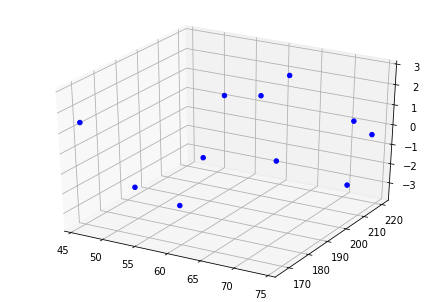

In [25]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Xdot[:,1], Xdot[:,2], r_, c='b', alpha=1)
plt.show()

Let's create a prediction function and make some predictions for different ages and weights not contained in the dataset.

In [26]:
def predict(X): # X can be matrix, vector, or even a list
  yhat_=X@w_
  return yhat_

for age,weight in [(50,100),(60,120),(75,150)]:
  print("The blood pressure of a %d year old person with weight of %f pounds in average is = %f"\
        %(age,weight,predict([1,age,weight])))

The blood pressure of a 50 year old person with weight of 100.000000 pounds in average is = 107.550757
The blood pressure of a 60 year old person with weight of 120.000000 pounds in average is = 122.862088
The blood pressure of a 75 year old person with weight of 150.000000 pounds in average is = 145.829084


But we should not forget about the uncertainty of our predictions. 

## 4. Make hypothesis testing <a name="Hypothesis"></a>

In the case of multiple linear regression, we can create a t-test for the individual regression coefficients in the same way as we did for the simple linear regression. We print the result in a format, which resembles the statsmodels OLS results.

In [27]:
from scipy import stats
Var=['Intercept','Age','Weight']

def OLSresults(X,y_):     # X now represents the design matrix
    N,D=X.shape           # Do not forget that D now incorporates the constant term, as well
    conflevel=95
    alpha=1-conflevel/100
    df=N-D
    tscore=abs(stats.t.ppf(alpha/2, df))
    pd.options.display.float_format = '{:,.3f}'.format
    H=X@inv(X.T@X)@X.T
    I=np.eye(N)
    r_=(I-H)@y_
    w_=inv(X.T@X)@X.T@y_
    MSE=float(1/(N-D)*r_.T@r_)
    S_w_=np.sqrt(np.diag(MSE*inv(X.T@X))[:,np.newaxis])
    table=pd.DataFrame(columns=["Input","Coefficient","Std. error","t-statistic","p-value","[0.025","0.975]"])
    for i in range(D):
        t_stat=w_[i,0]/S_w_[i,0]
        pval = stats.t.sf(np.abs(t_stat),df)*2
        LCL=w_[i,0]-tscore*S_w_[i,0]
        UCL=w_[i,0]+tscore*S_w_[i,0]
        table=table.append({"Input":Var[i],"Coefficient":w_[i,0],"Std. error":S_w_[i,0],
                            "t-statistic":t_stat,"p-value":pval,"[0.025":LCL,"0.975]":UCL},ignore_index=True)
    return table
print(OLSresults(Xdot,y_))

       Input  Coefficient  Std. error  t-statistic  p-value  [0.025  0.975]
0  Intercept       30.994      11.944        2.595    0.032   3.452  58.537
1        Age        0.861       0.248        3.470    0.008   0.289   1.434
2     Weight        0.335       0.131        2.563    0.034   0.034   0.636


As it can be observed, each regression coefficient significantly differs from zero. We can also observe that the confidence interval for the intercept is very wide, thus we should not provide any meaning for the intercept. We can also observe that the LCL for the weight with a 95% confidence level is close to zero.

The F-test can be also created in the same way as we did for the simple linear regression. With F-test, we test whether all coefficients are zero vs. at least one regression coefficient is nonzero.

In [28]:
def anova(X,y_):
    N,D=X.shape        # Do not forget that D now incorporates the constant term, as well
    H=X@inv(X.T@X)@X.T
    I=np.eye(N)
    r_=(I-H)@y_
    yhat_=H@y_
    SSR=np.sum((yhat_-y_.mean())**2)
    SSE=np.sum((y_-yhat_)**2)
    SST=np.sum((y_-y_.mean())**2)
    MSR=SSR/(D-1)
    MSE=SSE/(N-D)
    Fscore=MSR/MSE
    pvalue=stats.f.sf(Fscore,D-1,N-D)
    print("F-test and corresponding p-value:",Fscore,pvalue)
    if pvalue<=0.0001:
        stars='****'     # corresponding to at least 99.99%
    elif pvalue<=0.001: 
        stars='***'      # corresponding to at least 99.9%
    elif pvalue<=0.01: 
        stars='**'       # corresponding to at least 99%
    elif pvalue<=0.05:
        stars='*'        # corresponding to at least 95%
    else:
        stars=''         # corresponding to <95%
    print("===========================================================================")
    print("ANOVA (1 way) |  df  |     SS      |     MS      |  F test   |  p value")
    print("---------------------------------------------------------------------------")
    print(("Regression    | %3d  |  %9.3f  |  %9.3f  |  %6.3f  | %7.6f "+stars)%(D-1,SSR,MSR,Fscore,pvalue))
    print("Residuals     | %3d  |  %9.3f  |  %9.3f  |           |"%(N-D,SSE,MSE))
    print("Total         | %3d  |  %9.3f  |             |           |"%(N-1,SST))
    print("===========================================================================")
    return
anova(Xdot,y_)

F-test and corresponding p-value: 168.76456586243393 2.873566636570687e-07
ANOVA (1 way) |  df  |     SS      |     MS      |  F test   |  p value
---------------------------------------------------------------------------
Regression    |   2  |   1813.916  |    906.958  |  168.765  | 0.000000 ****
Residuals     |   8  |     42.993  |      5.374  |           |
Total         |  10  |   1856.909  |             |           |


Thus, our multiple linear regression model is significantly better than the constant average value of the output.

## 5. Calculate RSS and R-squared <a name="CalcRSSR2"></a>

Besides creating the 95% confidence interval's, let's see how good our model fits the data. For this reason, let's calculate the residual sum of squares: $\mathrm{RSS}=\mathrm{\Sigma} \mathbf r^2$

In [29]:
RSS=np.sum(r_**2)
print("Residual Sum of Squares: RSS =",RSS)

Residual Sum of Squares: RSS = 42.992822784932336


The estimated standard deviation of the error ($\hat\sigma$) is:

In [30]:
print("Estimated standard deviation of the errror:",np.sqrt(RSS))

Estimated standard deviation of the errror: 6.556891243945742


Then the R-squared value is:

In [31]:
TSS=np.sum((y_-y_.mean())**2)
print("R-squared value: R2 =",1-RSS/TSS)

R-squared value: R2 = 0.9768471041498945


That is very very high. We know that one additional independent variable, by itself, increases the R-squared value. So let's calculate the adjusted R-squared value.

In [32]:
print("Adjusted R-squared value: R2_adj =",1-(RSS/(N-D-1))/(TSS/(N-1)))

Adjusted R-squared value: R2_adj = 0.9710588801873681


The adjusted R-squared value is around the same.

## 6. Using scikit-learn and statsmodel libraries <a name="SklearnStatsmodel"></a>

Now, that we have a good understanding of the multiple linear regression, let's see how we can use the scikit-learn library (https://scikit-learn.org/stable/index.html). Please, note that only the input matrix is provided for the scikit-learn linear regression fit method (denoted by $\mathbf {X}$ in the book). 

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression
multiple_linregr=LinearRegression().fit(X,y_)
print("Point estimate for the regression coefficients:")
print("Intercept =",multiple_linregr.intercept_[0])
print("Coefficient for Age =",multiple_linregr.coef_[0][0])
print("Coefficient for Weigth =",multiple_linregr.coef_[0][1])

Point estimate for the regression coefficients:
Intercept = 30.994102952348328
Coefficient for Age = 0.8614146864683596
Coefficient for Weigth = 0.3348591971656901


Calculate the R-squared value with the *score* method of the LinearRegression class. The adjusted R-squared value can be calculated from this R-squared value.

In [34]:
r2=multiple_linregr.score(X,y_)
r2_adj=1-(1-r2)*(N-1)/(N-D-1)
print("R-squared =",r2)
print("Adjusted R-squared =",r2_adj)

R-squared = 0.9768471041502093
Adjusted R-squared = 0.9710588801877615


So far so good! Now, calculate the mean square error (MSE) using the scikit-learn metric (*mean_squared_error*). Do not forget that this is a biased estimate of the variance of the true error. Thus, we should also calculate the unbiased version of it.

In [35]:
MSE_sk=mean_squared_error(y_, multiple_linregr.predict(X))
print("Biased MSE from scikit-learn =",MSE_sk)
print("Unbiased MSE using biased scikit-learn MSE is =",N/(N-D-1)*MSE_sk)

Biased MSE from scikit-learn = 3.908438434940717
Unbiased MSE using biased scikit-learn MSE is = 5.374102848043486


Now, let's check the F-score and associated p-value using the *f_regression* method from scikit-learn feature selection.

In [36]:
Fscore,pvalue=f_regression(X,np.ravel(y_))
print("ANOVA F-scores:",Fscore)
print("Corresponding p-values:",pvalue)

ANOVA F-scores: [204.4761356  146.15959582]
Corresponding p-values: [1.70776615e-07 7.22667789e-07]


Oops! We get a pair of F-test and corresponding p-values. As you can see, this does not agree with our calculation. The reason is that "f-regression" is used for feature selection in scikit-learn. The F-scores and their p-values correspond to simple linear regression containing only a single independent variable. In our case, there two, thus two F-scores and two corresponding p-values are returned. We can check this easily.

In [37]:
def Fscore(x_,y_):
    slr=LinearRegression().fit(x_,y_)
    SSR=np.sum((slr.predict(x_)-y_.mean())**2)
    SSE=np.sum((y_-slr.predict(x_))**2)
    MSR=SSR/1
    MSE=SSE/(N-2)
    Fscore=MSR/MSE
    pvalue=stats.f.sf(Fscore,1,N-2)
    return Fscore,pvalue

x_=Xdot[:,0].reshape(-1, 1)
print("F-score and p-value for the 'age' variable:",Fscore(x_,y_))
x_=Xdot[:,1].reshape(-1, 1)
print("F-score and p-value for the 'weight' variable:",Fscore(x_,y_))

F-score and p-value for the 'age' variable: (0.0, 1.0)
F-score and p-value for the 'weight' variable: (204.47613559640004, 1.7077661468928465e-07)


Finally, let's see the summary of the OLS with the *statsmodels* library.

In [38]:
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
data=data.rename(index=str, columns={"Systolic blood pressure": "BloodPressure","Age in years":"Age",\
                                     "Weight in pounds":"Weight"})
model = ols(formula = 'BloodPressure ~ Age + Weight', data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          BloodPressure   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     168.8
Date:                Fri, 09 Oct 2020   Prob (F-statistic):           2.87e-07
Time:                        11:05:41   Log-Likelihood:                -23.106
No. Observations:                  11   AIC:                             52.21
Df Residuals:                       8   BIC:                             53.40
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.9941     11.944      2.595      0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


We have two warnings we should check. The one in red warns that due to the limited number of observations, we should not trust the normality test. Remember that confidence intervals are built with the assumption that the data has a normal distribution.  

The other is the condition number, which might indicate the presence of collinearity.

## 7. Checking for colliniarity <a name="CheckColliniarity"></a>

As we have seen at the beginning of the lab exercise, the rank of the design matrix is the same as the number of regression coefficients (age, weight, and the constant term)., which implies that there is no column of $\mathbf {\dot X}$ that can be calculated as a linear combination of the rest of the columns of $\mathbf {\dot X}$. Now, let's calculate the condition number as the ratio of the largest to the smallest eigenvalue of the matrix product $\mathbf {\dot X}^\top\mathbf {\dot X}$: 

In [39]:
eigval,eigvect=eigh(Xdot.T@Xdot)
print("Eigenvalues of the product matrix:")
print(eigval[:,np.newaxis])
print("Condition number =",np.sqrt(eigval.max()/eigval.min()))

Eigenvalues of the product matrix:
[[3.76601829e-02]
 [1.64291587e+02]
 [4.64856671e+05]]
Condition number = 3513.324963837358


There are no eigenvalues near zero, and although the condition number is quite high, still under $10^4$, which we set in the book as a threshold. Because the condition number is high - although still under $10^4$, which we set in the book as a threshold - let's calculate the variance inflation factors.

In [40]:
def vif(X,idx):
    from sklearn.linear_model import LinearRegression 
    linregr=LinearRegression()
    X_notidx=np.delete(X,idx,axis=1)
    X_idx=X[:,idx]
    linregr.fit(X_notidx,X_idx)
    R2=linregr.score(X_notidx,X_idx)
    return(1.0/(1.0-R2))

for idx in range(2):
    print(vif(X,idx))

9.52502151287206
9.525021512872101


The same result can be obtained using the *statsmodels* library.

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
print(variance_inflation_factor(Xdot,1))
print(variance_inflation_factor(Xdot,2))

9.52502151287209
9.525021512872081


The variance inflation factors are close to 10, which suggests that there is some collinearity between the independent variables 'Age' and 'Weight'. Let's, check the Pearson correlation coefficient:

In [42]:
np.corrcoef(X,rowvar=False)

array([[1.        , 0.94605146],
       [0.94605146, 1.        ]])

The Pearson correlation coefficient is close to 1 ($\rho=0.95$), which suggests a strong positive correlation between 'Age' and 'Weight'. Based on this dataset, as a person gets older, the bodyweight also increases proportionally.  Of course, this is not what we should expect in general, but in this particular case, we created a survey where the age and weight are strongly correlated.

Let's remove the *Weight* input variable and use the *Age* as predictor only.

In [43]:
model = ols(formula = 'BloodPressure ~ Age', data=data).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          BloodPressure   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     204.5
Date:                Fri, 09 Oct 2020   Prob (F-statistic):           1.71e-07
Time:                        11:05:41   Log-Likelihood:                -26.402
No. Observations:                  11   AIC:                             56.80
Df Residuals:                       9   BIC:                             57.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     58.7055      6.452      9.098      0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


As one can observe, the R-square value remained almost the same, e.g., from 0.97 decreased to only 0.95. Thus, using both predictors did not provide a significantly better model.

We will discuss the consequences of multicollinearity in a later lab exercise.

<img src = "images/AML1-Cover.png" width = 110, align = "left" style="margin:0px 20px">

**Note:** This Jupyter Notebook is accompanying the book: <br> $\;\;\;\;\;\;$ <b>Advanced Machine Learning Made Easy</b> <br> $\;\;\;\;\;\;$ From Theory to Practice with NumPy and scikit-learn <br> $\;\;\;\;\;\;$ <i> Volume 1: Generalized Linear Models</i><br>
by Ferenc Farkas, Ph.D. 

If you find this Notebook useful, please support me by buying the book at [Leanpub](http://leanpub.com/AML1). <br>
Copyright notice: This Jupyter Notebook is made available under the [MIT License](https://opensource.org/licenses/MIT).